# Visualize clusters

## Import modules

In [1]:
import sys
sys.path.append('../xSiGra_model')
from utils import Cal_Spatial_Net
import warnings
warnings.filterwarnings('ignore')

In [3]:
import argparse
import pandas as pd
import os
import scanpy as sc
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import cv2
import torchvision.transforms as transforms
from utils import Cal_Spatial_Net, Stats_Spatial_Net, _hungarian_match
from train_transformer import train_nano_fov, test_nano_fov, get_explanations
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt
import random
from scipy.optimize import linear_sum_assignment
from transModel import ClusteringLayer
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from sklearn import preprocessing
os.environ['R_HOME'] = '/opt/R/4.0.2/lib/R'
os.environ['R_USER'] = '~/anaconda3/lib/python3.8/site-packages/rpy2'
os.environ['LD_LIBRARY_PATH'] = '/opt/R/4.0.2/lib/R/lib'
os.environ['PYTHONHASHSEED'] = '1234'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--root', type=str, default='/N/project/st_brain/abudhkar/dataset/nanostring/lung13')
parser.add_argument('--epochs', type=int, default=2000)
parser.add_argument('--id', type=str, default='fov1')
parser.add_argument('--img_name', type=str, default='F001')
parser.add_argument('--neurons', type=str, default='512,30')
parser.add_argument('--num_layers', type=str, default="2")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument('--save_path', type=str, default='../checkpoint/nanostring_train_lung13_tutorial/')
parser.add_argument('--ncluster', type=int, default=8)
parser.add_argument('--repeat', type=int, default=1)
parser.add_argument('--use_gray', type=float, default=0)
parser.add_argument('--test_only', type=int, default=1)
parser.add_argument('--pretrain', type=str, default='final_100_0.pth')
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument('--img_size', type=str, default='60,60')
parser.add_argument('--cluster_method', type=str, default='leiden')
parser.add_argument('--num_fov', type=int, default=20)
parser.add_argument('--dataset', type=str, default='lung13')

opt = parser.parse_args(args=[])

## Load best model

In [5]:
adata_pred = sc.read("../saved_adata/"+opt.dataset+"_adata_pred.h5ad")

In [6]:
# Use best resolution after tuning for lung13
res = 0.3681250000000001

# # OR use resolution search for leiden
# def res_search(adata_pred, ncluster, seed, iter=200):
#     start = 0; end = 3
#     i = 0
#     while(start < end):
#         if i >= iter: return res
#         i += 1
#         res = (start + end) / 2
#         print(res)
#         random.seed(seed)
#         os.environ['PYTHONHASHSEED'] = str(seed)
#         np.random.seed(seed)
#         torch.manual_seed(seed)
#         torch.cuda.manual_seed(seed)
#         os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
#         torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = False
#         sc.tl.leiden(adata_pred, random_state=seed, resolution=res)
#         count = len(set(adata_pred.obs['leiden']))
#         if count == ncluster:
#             print('find', res)
#             return res
#         if count > ncluster:
#             end = res
#         else:
#             start = res
#     raise NotImplementedError()
    
# res = res_search(adata_pred, opt.ncluster, opt.seed)
sc.tl.leiden(adata_pred, resolution=res, key_added='leiden', random_state=opt.seed)

obs_df = adata_pred.obs.dropna()

ARI = adjusted_rand_score(obs_df['leiden'], obs_df['merge_cell_type'])
print('ARI: %.2f'%ARI)

ARI: 0.63


## Match clusters to ground truth for visualization

In [7]:
labels = obs_df['merge_cell_type']
def _hungarian_match(flat_preds, flat_target, preds_k, target_k):
    num_samples = flat_target.shape[0]
    num_k = preds_k
    num_k_tar = target_k
    num_correct = np.zeros((num_k, num_k_tar))
    for c1 in range(num_k):
        for c2 in range(num_k_tar):
            votes = int(((flat_preds==c1)*(flat_target==c2)).sum())
            num_correct[c1, c2] = votes
    match = linear_sum_assignment(num_samples-num_correct)
    match = np.array(list(zip(*match)))
    res = []
    for out_c, gt_c in match:
        res.append((out_c, gt_c))
    return res

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
gt = le.fit_transform(labels)

match = _hungarian_match(adata_pred.obs["leiden"].astype(np.int8), gt.astype(np.int8), opt.ncluster,8)

In [8]:
le = preprocessing.LabelEncoder()
gt = le.fit_transform(labels)

match = _hungarian_match(adata_pred.obs["leiden"].astype(np.int8), gt.astype(np.int8), opt.ncluster,8)

# leiden to ground truth cell type matching
dict_mapping = {}

# Leiden cluster cell type
dict_name = {}

# Ground truth cluster cell type
dict_gtname = {}
for i in gt:
    dict_gtname[i] = le.classes_[i]
label = list(sorted(dict_gtname.values()))

dict_gtname = {}
for i in match:
    dict_mapping[str(i[0])] = i[1]
    dict_name[i[0]] = le.classes_[i[1]]
    dict_gtname[i[1]] = le.classes_[i[0]]

obs_df = obs_df.replace({"leiden": dict_mapping})
adata_pred.obs["leiden"] = obs_df["leiden"]

## Visualize ground truth and xSiGra clusters

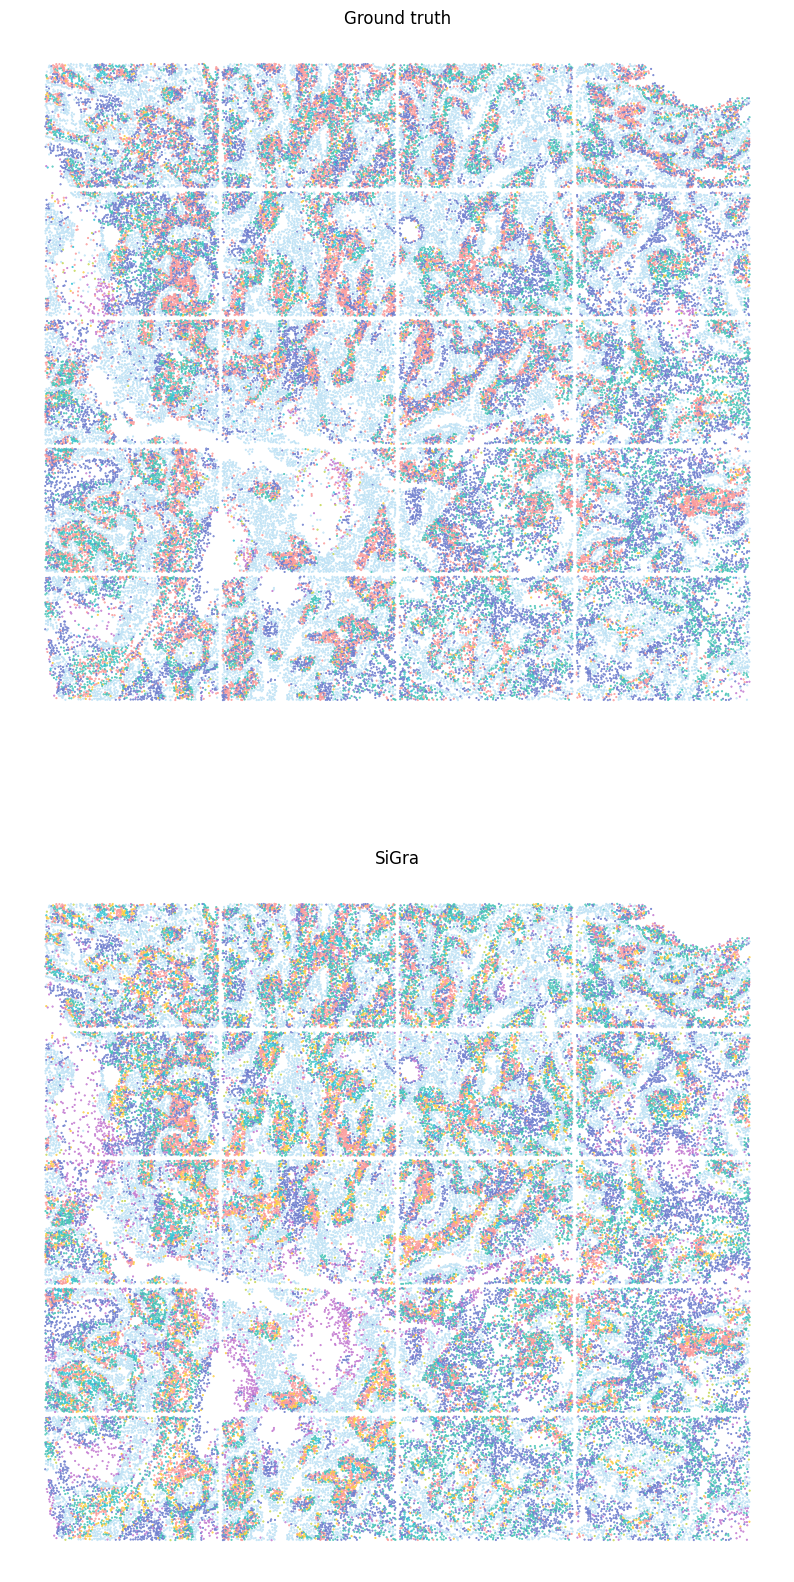

In [9]:

# Plot ground truth and computed clusters
cell_type = list(set(adata_pred.obs['merge_cell_type']))
ground_truth = [i for i in range(len(cell_type))]
gt = np.zeros(adata_pred.obs['merge_cell_type'].shape)
for i in range(len(ground_truth)):
    ct = cell_type[i]
    idx = (adata_pred.obs['merge_cell_type'] == ct)
    gt[idx] = i
gt = gt.astype(np.int32)

pred = adata_pred.obs['leiden'].to_numpy().astype(np.int32)


match = _hungarian_match(pred, gt, len(set(pred)), len(set(gt)))

colors = {'lymphocyte': '#fa9898ff',
        'Mcell': '#6879ccff',
        'myeloid': '#6879ccff',
        'tumors': "#bce1f5ff",
        'epithelial': "#c2d64fff",
        'mast': '#fccc3dff',
        'endothelial': '#2dc2d6ff',
        'fibroblast': '#42c2b5ff',
        'neutrophil': '#c174cfff'
    }
cs = ['' for i in range(pred.shape[0])]
gt_cs = ['' for i in range(pred.shape[0])]

for ind, j in enumerate(adata_pred.obs['merge_cell_type'].tolist()):
    gt_cs[ind] = colors[j]


for outc, gtc in match:
    idx = (pred == outc)
    for j in range(len(idx)):
        if idx[j]:
            cs[j] = colors[cell_type[gtc]]

colors = {0: '#2dc2d6ff',
         1: '#c2d64fff',
        1: '#c2d64fff',
        2: "#42c2b5ff",
        3: "#fa9898ff",
        4: '#fccc3dff',
        5: '#6879ccff',
        6: '#c174cfff',
       7: '#bce1f5ff'
    }
for ind, j in enumerate(adata_pred.obs['leiden'].tolist()):
    cs[ind] = colors[int(j)]
adata_pred.obs['cmap'] = cs
adata_pred.obs['gtcmap'] = gt_cs

genedf = sc.get.obs_df(
        adata_pred,
        keys=["leiden", 'cmap', 'gtcmap'])

cxg, cyg = adata_pred.obs['cx_g'], adata_pred.obs['cy_g']
colors = adata_pred.obs['gtcmap']
fig, axs = plt.subplots(2,1,figsize=(10,20))
#axs[0].invert_yaxis()
axs[0].scatter(cxg, cyg, c=colors, s=0.25)
axs[0].axis('off')
axs[0].set_title('Ground truth')
extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('../cluster_results_gradcam_gt1/'+opt.dataset+'/gt.png', bbox_inches=extent)


colors = adata_pred.obs['cmap']
#axs[1].invert_yaxis()
axs[1].scatter(cxg, cyg, c=colors, s=0.25)
axs[1].axis('off')
axs[1].set_title('SiGra')
extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('../cluster_results_gradcam_gt1_tutorial/'+opt.dataset+'/pred.png', bbox_inches=extent)




## Visualize raw vs enchanced data

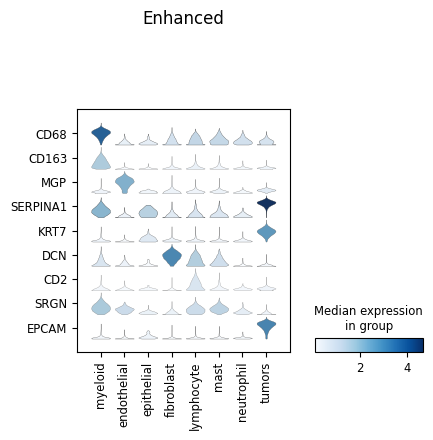

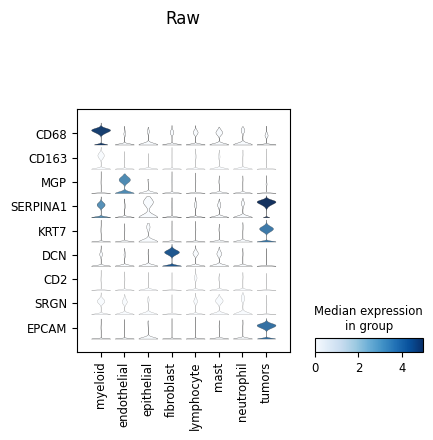

In [10]:

# Violin plot for marker genes in raw and enchanced data
import scanpy as sc
markers = ['CD68', 'CD163', 'MGP', 'SERPINA1', 'KRT7', 'DCN', 'CD2', 'SRGN', 'EPCAM']
adata_copy = adata_pred.copy()
order = None

if 'Mcell' in adata_pred.obs["merge_cell_type"].tolist():
    order = ['Mcell','endothelial','epithelial','fibroblast','lymphocyte','mast','neutrophil','tumors']
else:
    order = ['myeloid','endothelial','epithelial','fibroblast','lymphocyte','mast','neutrophil','tumors'] 
adata_copy.obs['merge_cell_type'] = adata_copy.obs['merge_cell_type'].astype('category')  
adata_copy.obs['merge_cell_type'].cat.reorder_categories(order,inplace=True)

sc.pl.stacked_violin(adata_copy, markers, groupby='merge_cell_type', dendrogram=False,layer='recon', title="Enhanced", swap_axes=True, order=order)
sc.pl.stacked_violin(adata_copy, markers, groupby='merge_cell_type', dendrogram=False, title="Raw", swap_axes=True, order=order)

